In [1]:
### This noteboook is used for dealing with problem in ContiguousSNP
import sys
import os
import zipfile

## import function from python_scripts
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from python_scripts.gene_level_MoM import * 
from python_scripts.pairwise_product_var_calculation import * 
from python_scripts.visualization import * 
from python_scripts.weight_function import * 

In [9]:
###unzip file
zip_files = [
    "../test_data/chr1_Contiguous1KSNP.zip",
    "../test_data/chr1_Contiguous1KSNP_LDpruned_08.zip",
    "../test_data/chr1_Contiguous1KSNP_LDpruned_09.zip",
    "../test_data/chr1_Random1KSNP.zip"
]
for zf in zip_files:
    with zipfile.ZipFile(zf, "r") as z:
        z.extractall("test_data")   
    print(f"Unzipped: {zf}")
##read data  
##Random snp
RandomSNP = pd.read_csv("test_data/chr1_Random1KSNP.raw", sep=r'\s+')
RandomSNP = RandomSNP.iloc[:, 6:].to_numpy()
##Contiguous snp
ContiguousSNP = pd.read_csv("test_data/chr1_Contiguous1KSNP.raw", sep=r'\s+')
ContiguousSNP = ContiguousSNP.iloc[:, 6:].to_numpy()

##Contiguous snp_LDpruned_08
ContiguousSNP_LDpruned_08 = pd.read_csv("test_data/chr1_Contiguous1KSNP_LDpruned_08.raw", sep=r'\s+')
ContiguousSNP_LDpruned_08 = ContiguousSNP_LDpruned_08.iloc[:, 6:].to_numpy()

##Contiguous snp_LDpruned_09
ContiguousSNP_LDpruned_09 = pd.read_csv("test_data/chr1_Contiguous1KSNP_LDpruned_09.raw", sep=r'\s+')
ContiguousSNP_LDpruned_09 = ContiguousSNP_LDpruned_09.iloc[:, 6:].to_numpy()

Unzipped: ../test_data/chr1_Contiguous1KSNP.zip
Unzipped: ../test_data/chr1_Contiguous1KSNP_LDpruned_08.zip
Unzipped: ../test_data/chr1_Contiguous1KSNP_LDpruned_09.zip
Unzipped: ../test_data/chr1_Random1KSNP.zip


#### **Experiment 1**: Use Allel frequency of ith and jth SNP $(p_i, p_j)$ and their covariance $\sigma_{ij}$  to represent pairwise product variance (Var$ Z_i Z_j$). We will use two simulated SNPs and compare their emprical variance and variance calculatged by formula to validate.

In [11]:
# set parameter
n = 2
p1 = 0.3
p2 = 0.4
sigmaij = 0.2
c = sigmaij / n  
p11 = p1 * p2 + c
p10 = p1 - p11
p01 = p2 - p11
p00 = 1 - p11 - p10 - p01

sizes = [1000,10000,100000,1000000,10000000]

for size in sizes:
     ### simulate two SNPs
     probs = np.array([p00, p01, p10, p11])
     codes = np.random.choice(4, size=(size, n), p=probs)
     
     X1 = ((codes == 2) | (codes == 3)).sum(axis=1)
     X2 = ((codes == 1) | (codes == 3)).sum(axis=1)
     X = np.column_stack((X1, X2))
     Z = (X - X.mean(axis=0)) / X.std(axis=0)
     var_zizj_formule= calculate_varZiZj(X)[0]
     empirical_var_zizj= np.var(Z[:,0]*Z[:,1])

     ### compare their result
     print(" ")
     print(f"Under the size of individual:{size}")
     print(f"The var(zizj) given by formule:{var_zizj_formule}")
     print(f"The empirical var(zizj):{empirical_var_zizj}")
     print(f"The relative error:{(var_zizj_formule - empirical_var_zizj) / empirical_var_zizj:.6f}")

 
Under the size of individual:1000
The var(zizj) given by formule:1.0930491488175385
The empirical var(zizj):1.1282400483349868
The relative error:-0.031191
 
Under the size of individual:10000
The var(zizj) given by formule:1.0760457503189094
The empirical var(zizj):1.073165339070894
The relative error:0.002684
 
Under the size of individual:100000
The var(zizj) given by formule:1.0783641362260958
The empirical var(zizj):1.0808853683171349
The relative error:-0.002333
 
Under the size of individual:1000000
The var(zizj) given by formule:1.0798903312183634
The empirical var(zizj):1.0767176125065232
The relative error:0.002947
 
Under the size of individual:10000000
The var(zizj) given by formule:1.0792743254740755
The empirical var(zizj):1.0791195637436948
The relative error:0.000143


#### **Experiment 1 Summary**: As sample size increases, the formula-based variance converges to the empirical variance, with relative error dropping to ~0.01% at 10M individuals. This validates the correctness of the closed-form expression for Var$(Z_i Z_j)$

#### **Experiment 2**: Investigate why the MoM estimator produces biased results with contiguous SNPs compared to random SNPs, by ploting the overall distribution of pairwise product variance Var$(Z_i Z_j)$.

------------------RandomSNP distribution-------------------


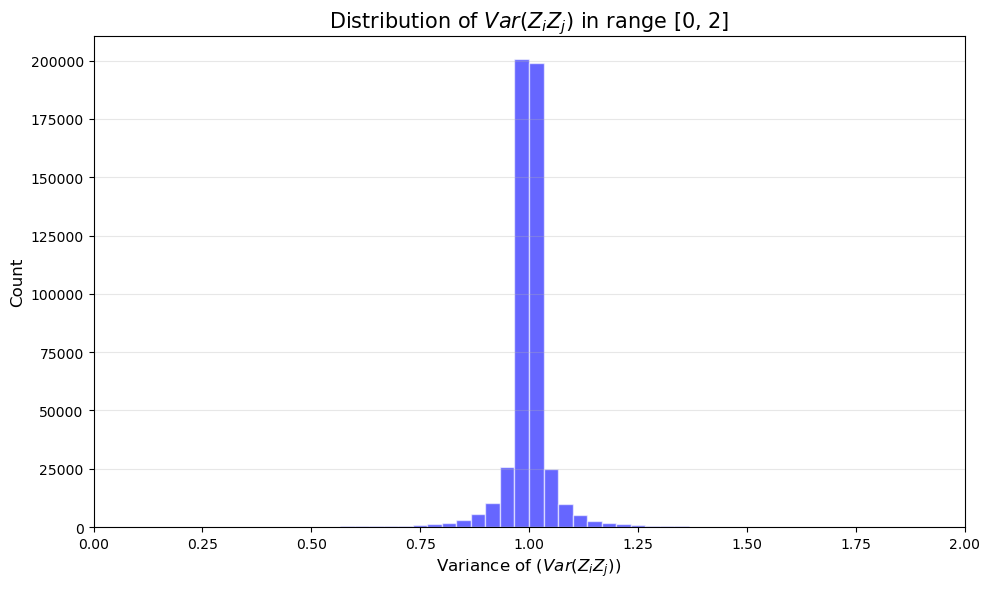

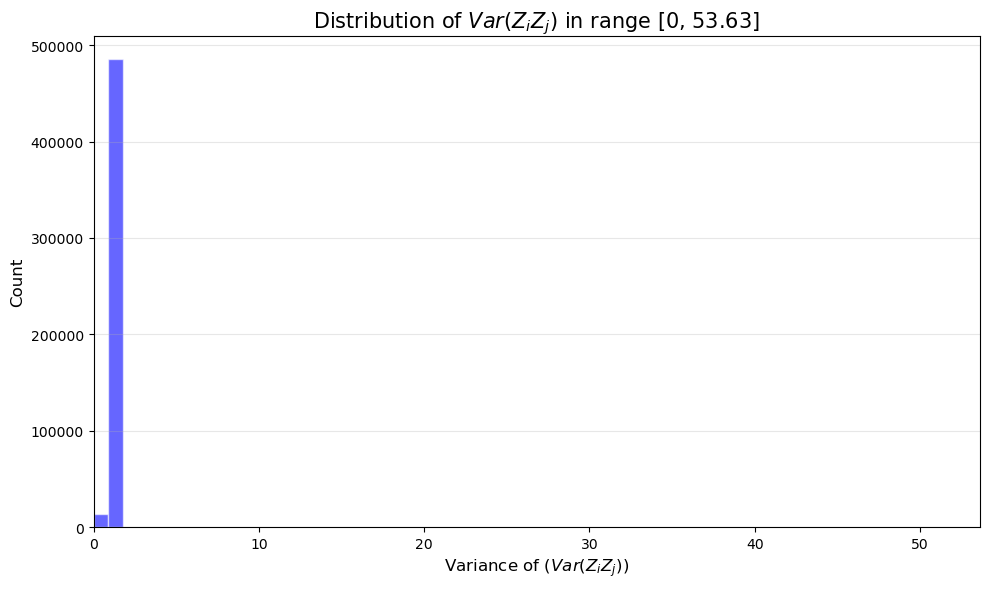

------------------ContiguousSNP distribution-------------------


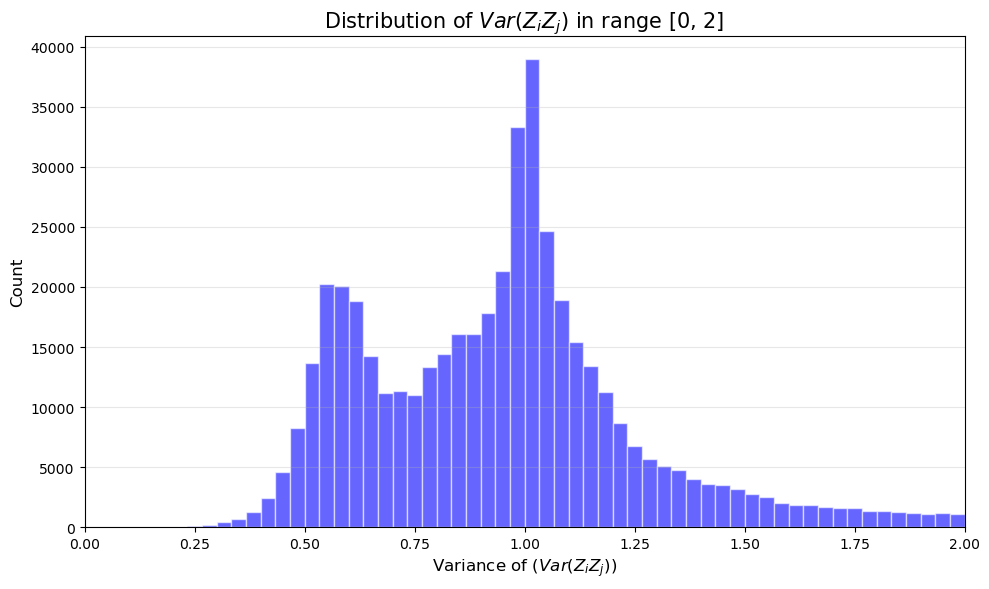

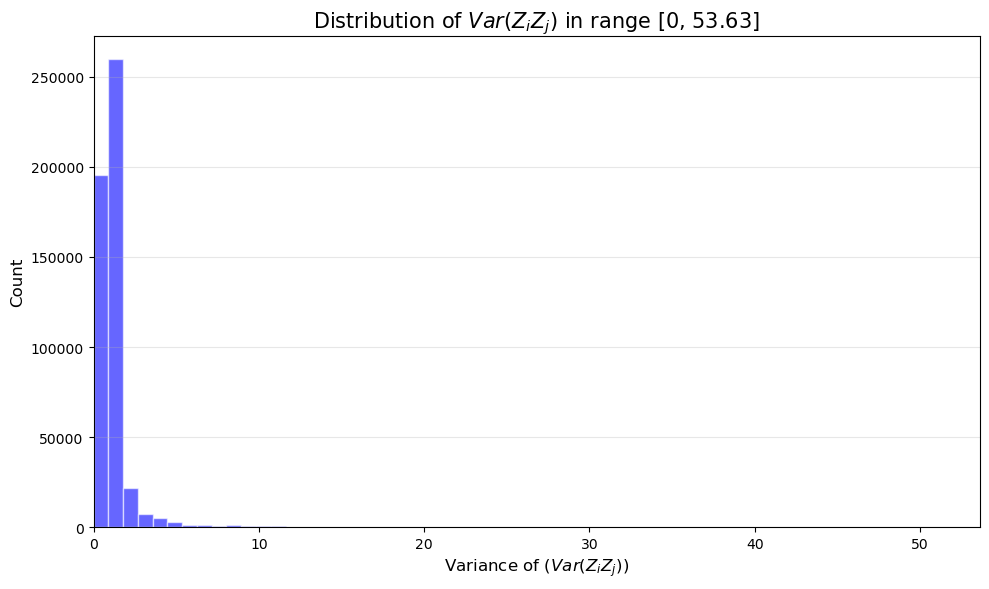

In [12]:
RandomSNP_varZiZj= calculate_varZiZj(RandomSNP)
ContiguousSNP_varZiZj= calculate_varZiZj(ContiguousSNP)

RandomSNP_varXiXj= calculate_varXiXj(RandomSNP)
ContiguousSNP_varXiXj= calculate_varXiXj(ContiguousSNP)

### draw the distribution
print("------------------RandomSNP distribution-------------------")
plot_distribution_varzizj(RandomSNP_varZiZj,0,2,60) ## pick variance with range 0 to 2 
plot_distribution_varzizj(RandomSNP_varZiZj,0,round(max(ContiguousSNP_varZiZj), 2),60)  ## draw the distriburion of all variance  
print("------------------ContiguousSNP distribution-------------------")
plot_distribution_varzizj(ContiguousSNP_varZiZj,0,2,60) ## pick variance with range 0 to 2 
plot_distribution_varzizj(ContiguousSNP_varZiZj,0,round(max(ContiguousSNP_varZiZj), 2),60) ## draw the distriburion of all variance

#### **Experiment 2 Summary**: Contiguous SNPs exhibit heavier tails with more extreme variance values compared to random SNPs, and the distribution is skewed.

#### **Experiment 3**: Investigate why the MoM estimator produces biased results with contiguous SNPs compared to random SNPs, by examining the distribution of pairwise product variance Var$(Z_i Z_j)$ and the LD ($r_{ij}$).

------------------RandomSNP case-------------------


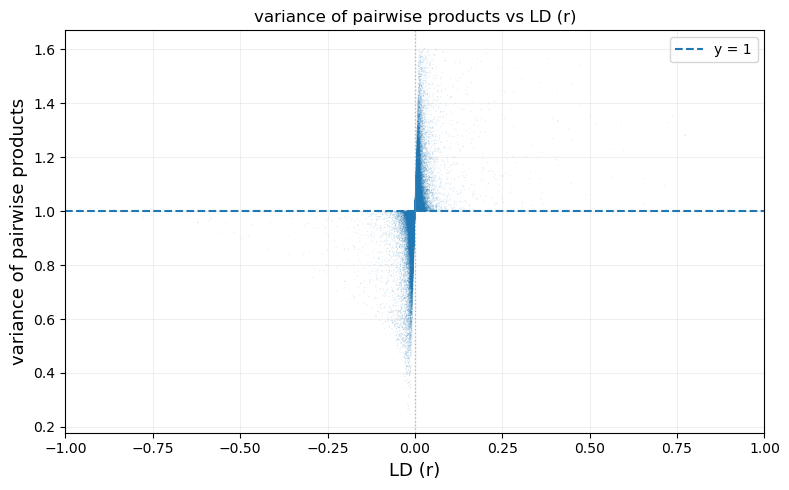

------------------ContiguousSNP case-------------------


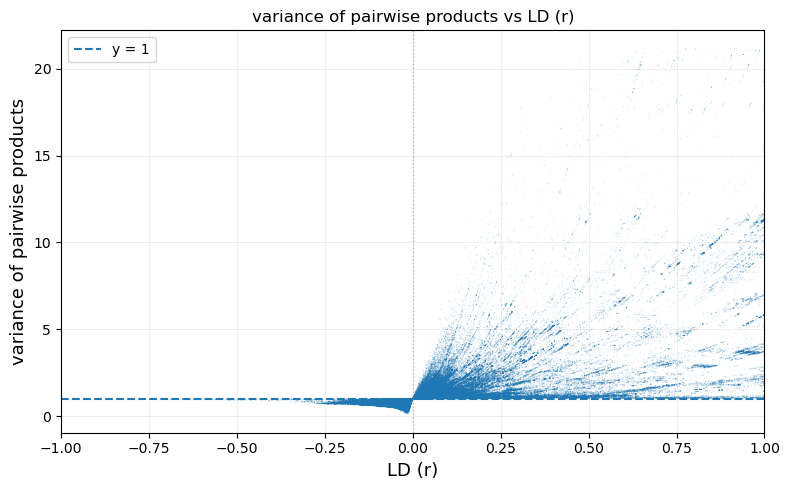

In [11]:
### experiment3: check the distibution of pairwise product variance (var zizj) against with LD (r)
def ld_vector(X):
    corr_matrix = np.corrcoef(X, rowvar=False)
    iu = np.triu_indices(X.shape[1], k=1)
    return corr_matrix[iu]


print("------------------RandomSNP case-------------------")
ld_RandomSNP =  ld_vector(RandomSNP)
plot_var_pairwise_products_against_ld(RandomSNP_varZiZj, ld_RandomSNP, q=0.999, save_path=None)


print("------------------ContiguousSNP case-------------------")
ld_ContiguousSNP =  ld_vector(ContiguousSNP)
plot_var_pairwise_products_against_ld(ContiguousSNP_varZiZj, ld_ContiguousSNP, q=0.999, save_path=None)

#### **Experiment 3 Summary**: High LD (particularly positive correlation) between Contiguous SNPs is the main factor behind inflated Var$(Z_i Z_j)$, which in turn biases the MoM estimator.

#### **Experiment 4**:  Same experiment as experiment 3, but use LD pruned SNP to draw the plot, this time SNPs with LD $r^2 > 0.9$ will be removed (294 remain, 1000 original).

------------------ContiguousSNP case witn LD-pruning (r2) threshold 0.9-------------------


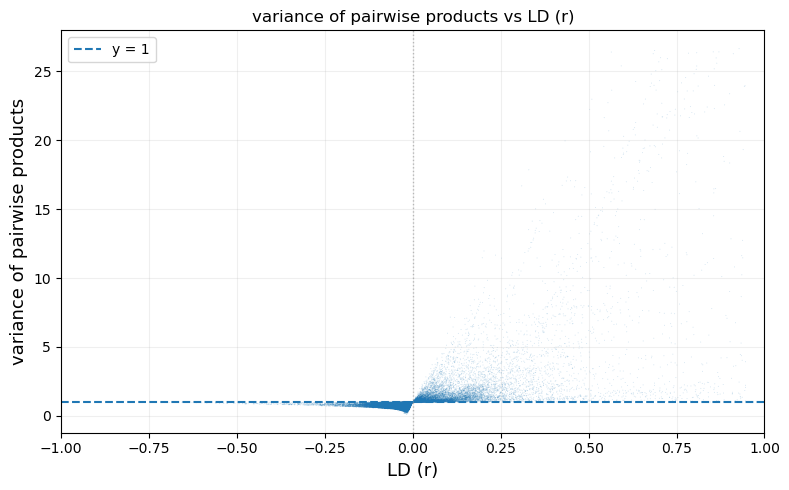

------------------ContiguousSNP case witn LD-pruning (r2) threshold 0.8-------------------


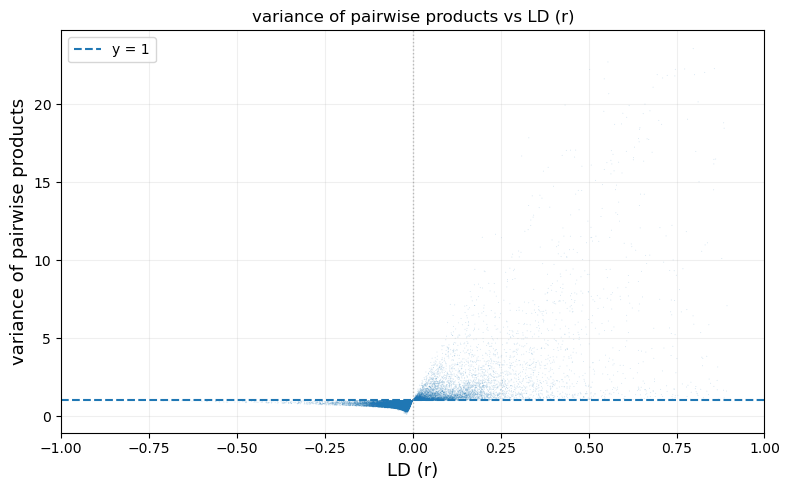

In [46]:
### experiment4: whether the LD pruned SNP can change the situation.
ContiguousSNP_varZiZj_LDpruned_08= calculate_varZiZj(ContiguousSNP_LDpruned_08)
ContiguousSNP_varZiZj_LDpruned_09= calculate_varZiZj(ContiguousSNP_LDpruned_09)

print("------------------ContiguousSNP case witn LD-pruning (r2) threshold 0.9-------------------")
ld_ContiguousSNP_LDpruned_09 =  ld_vector(ContiguousSNP_LDpruned_09)
plot_var_pairwise_products_against_ld(ContiguousSNP_varZiZj_LDpruned_09, ld_ContiguousSNP_LDpruned_09, q=0.999, save_path=None)

print("------------------ContiguousSNP case witn LD-pruning (r2) threshold 0.8-------------------")
ld_ContiguousSNP_LDpruned_08 =  ld_vector(ContiguousSNP_LDpruned_08)
plot_var_pairwise_products_against_ld(ContiguousSNP_varZiZj_LDpruned_08, ld_ContiguousSNP_LDpruned_08, q=0.999, save_path=None)


#### **Experiment 4 Summary**: after pruning, the pair (r > 0.948 or r < -0.948) has been removed from the plot.

#### **Experiment 5**: Determine whether removing highly correlated SNP pairs via LD pruning ($r^2$>0.9) yields better MoM estimation of GxG variance components.

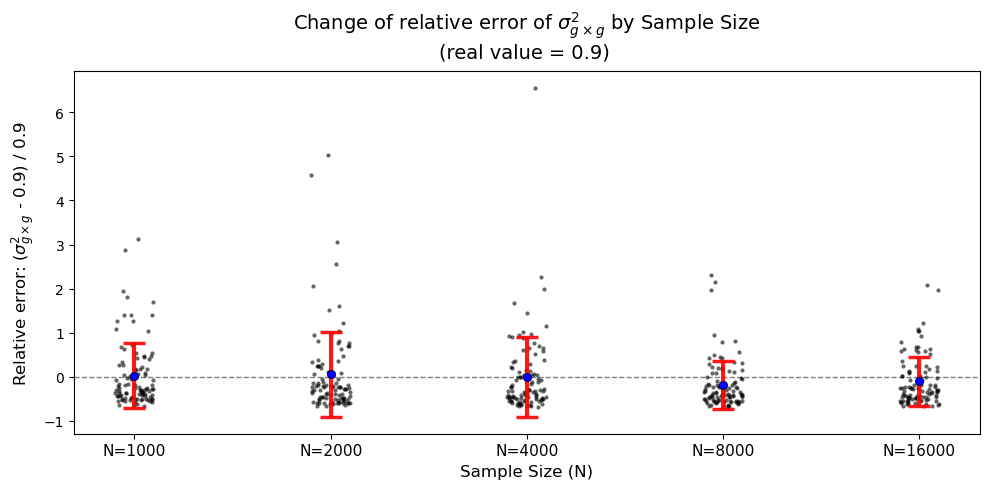

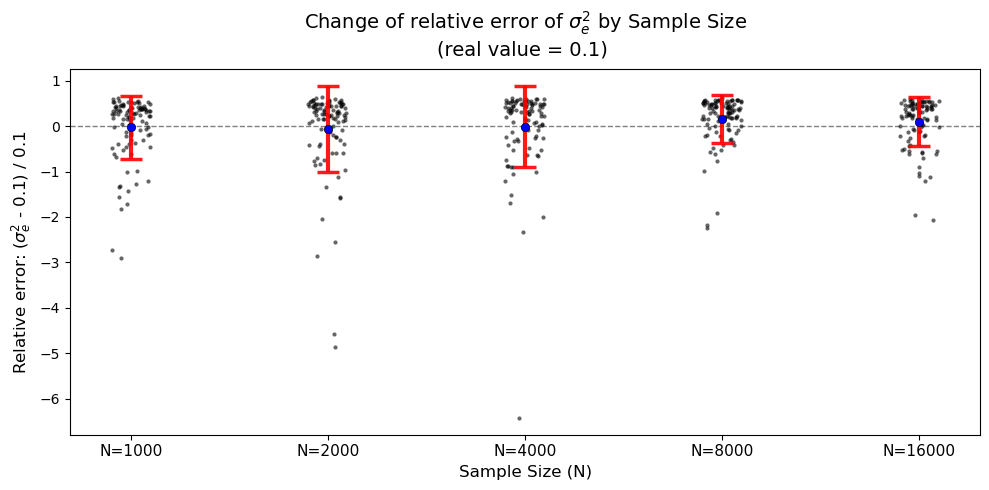

In [2]:
### experiment5: If we remove those highly correlated data pairs, can we achieve unbiased estimation?
## after pruning, the SNP number is 294 (original 1000)
#### visualise cluster result
individual_sizes = [1000,2000,4000,8000,16000]
result = read_MoM_results(individual_sizes,"../test_data/MoM_result_ContiguousSNP_after_pruning_09",294)
df_pruning_09 = [result[n] for n in individual_sizes]

plot_relative_error_accross_sample_size(
    *df_pruning_09, 
    basic_individual=1000, col_num=0, real_value=0.9
)

plot_relative_error_accross_sample_size(
    *df_pruning_09, 
    basic_individual=1000, col_num=1, real_value=0.1
)

#### **Experiment 5 summary**: It is hard to tell whether the estimation is biased or not since the y-axis is wide. The increase in sample size seems had no effect on standard error compared with Random SNP case. The reduction of the number may be caused several confounding effects, so we keep a pruned SNP number around 1000 in next simulation, as in the previous experiment.

#### **Experiment 6**: Extend Experiment 5 by starting with more SNPs so that after LD pruning, the remaining SNP count is close to the original 1,000 target.

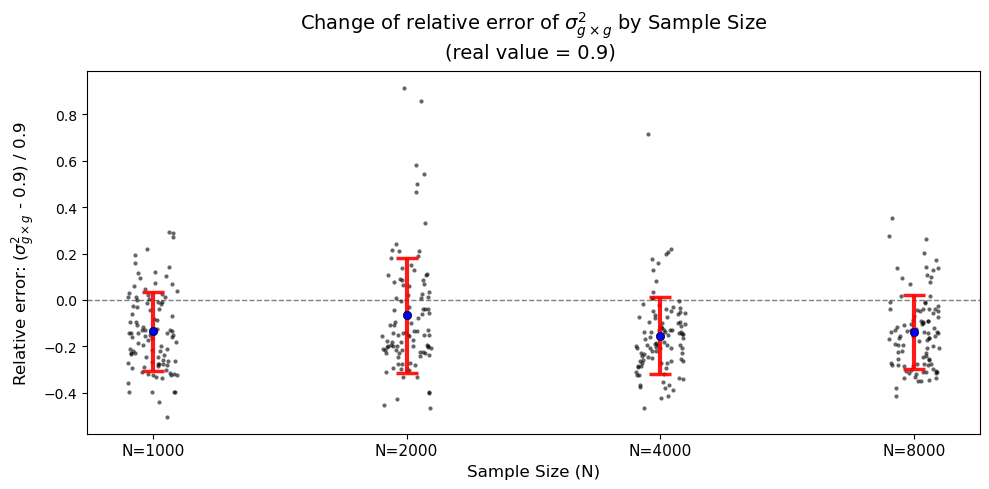

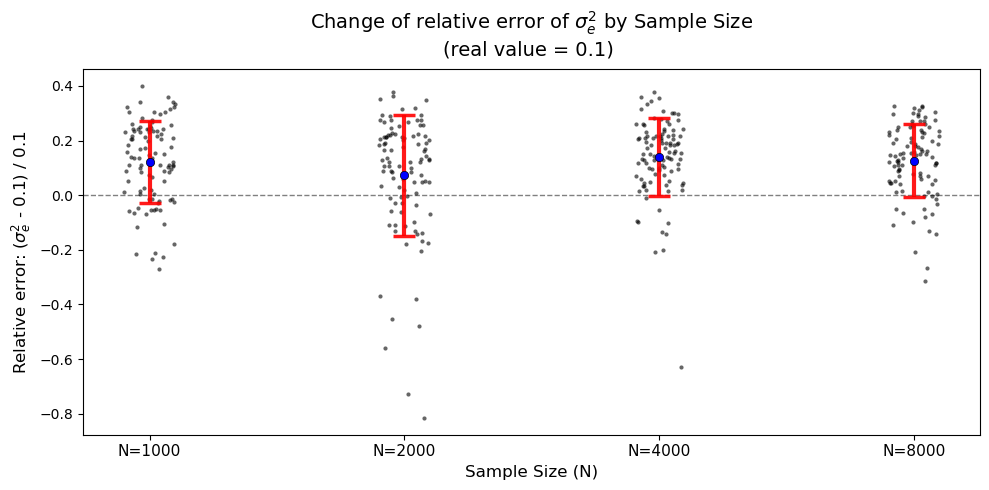

In [4]:
### experiment6: extension from experiment5 but increase SNPs size to around 1000?
## after pruning, the SNP number is 991(original 3500)
#### visualise cluster result
individual_sizes = [1000,2000,4000,8000]
result = read_MoM_results(individual_sizes,"../test_data/MoM_result_ContiguousSNP_after_pruning_09_SNP_991",991)
df_pruning_09 = [result[n] for n in individual_sizes]

plot_relative_error_accross_sample_size(
    *df_pruning_09, 
    basic_individual=1000, col_num=0, real_value=0.9
)

plot_relative_error_accross_sample_size(
    *df_pruning_09, 
    basic_individual=1000, col_num=1, real_value=0.1
)

#### **Experiment 6 summary**: With around 1000 post-pruning SNPs (vs. 294 in Experiment 5), the estimator become better. But the estimation is biased and the standard error is high. We still fail to solve the problem of contiguous SNP.

#### **Experiment 7**: Determine whether removing highly correlated SNP pairs via LD pruning ($r^2$>0.5) yields better MoM estimation of GxG variance components. Use Original 10K SNP and left around 900 SNP

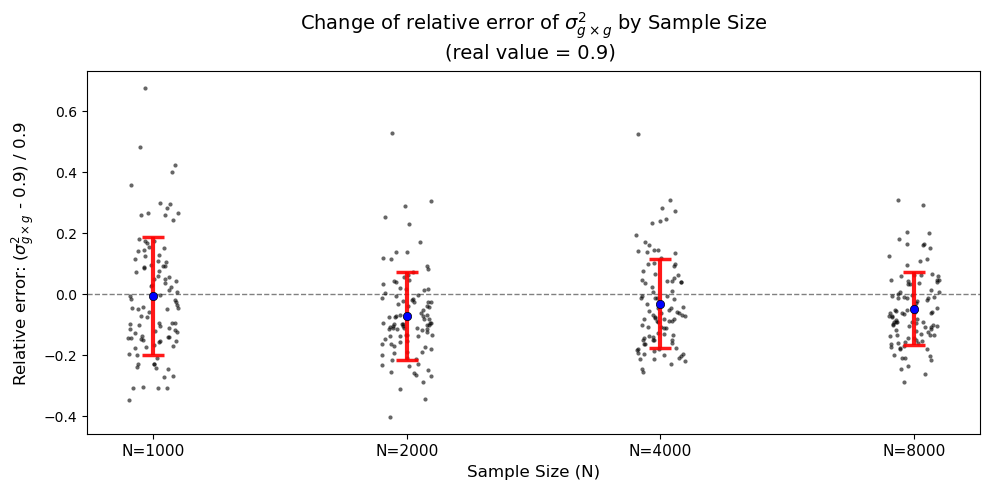

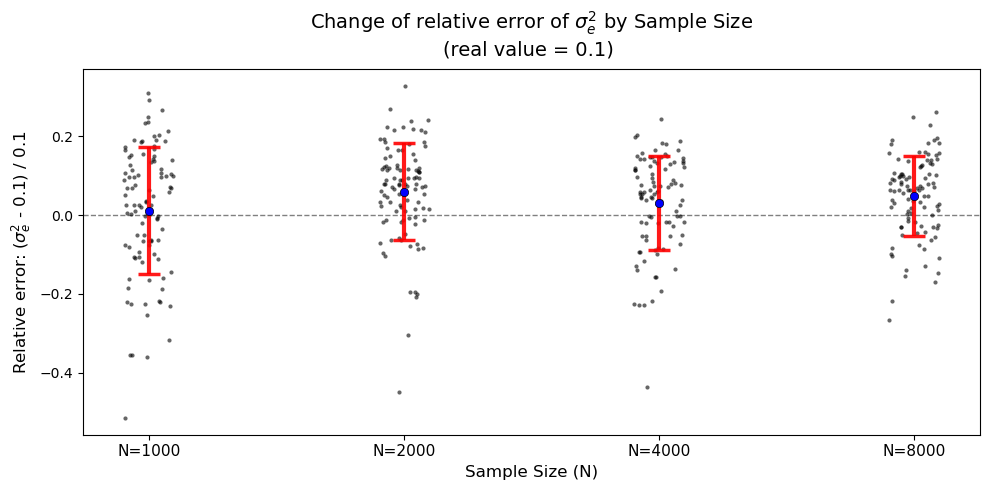

In [3]:
### experiment7: extension from experiment5 but LD pruning with r^2 > 0.5
## after pruning, the SNP number is 900(original 10k)
#### visualise cluster result
individual_sizes = [1000,2000,4000,8000]
result = read_MoM_results(individual_sizes,"../test_data/MoM_result_ContiguousSNP_after_pruning_05_SNP_861",861)
df_pruning_05 = [result[n] for n in individual_sizes]

plot_relative_error_accross_sample_size(
    *df_pruning_05, 
    basic_individual=1000, col_num=0, real_value=0.9
)

plot_relative_error_accross_sample_size(
    *df_pruning_05, 
    basic_individual=1000, col_num=1, real_value=0.1
)

#### **Experiment 8**: Extend Experiment 7 by filtering out maf < 0.05 and LD pruning ($r^2$>0.5). Use Original 10K SNP and left around 300 SNP

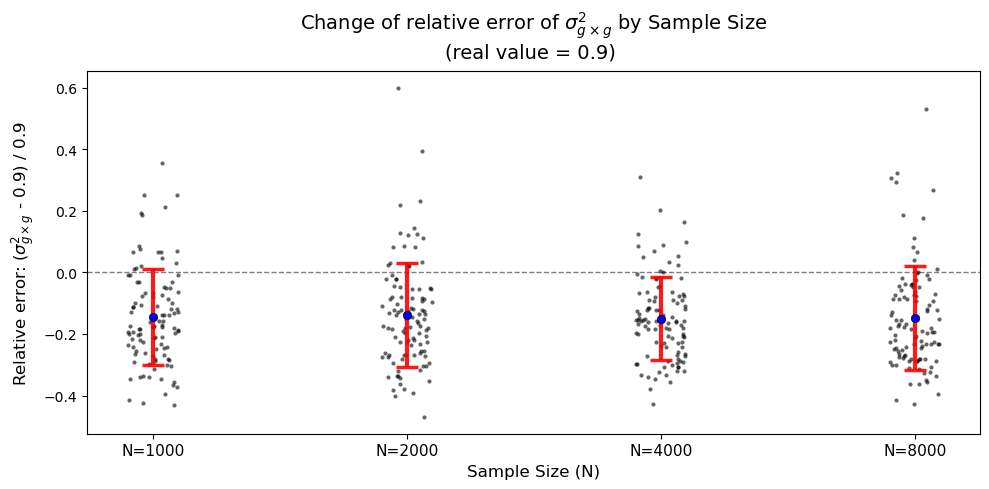

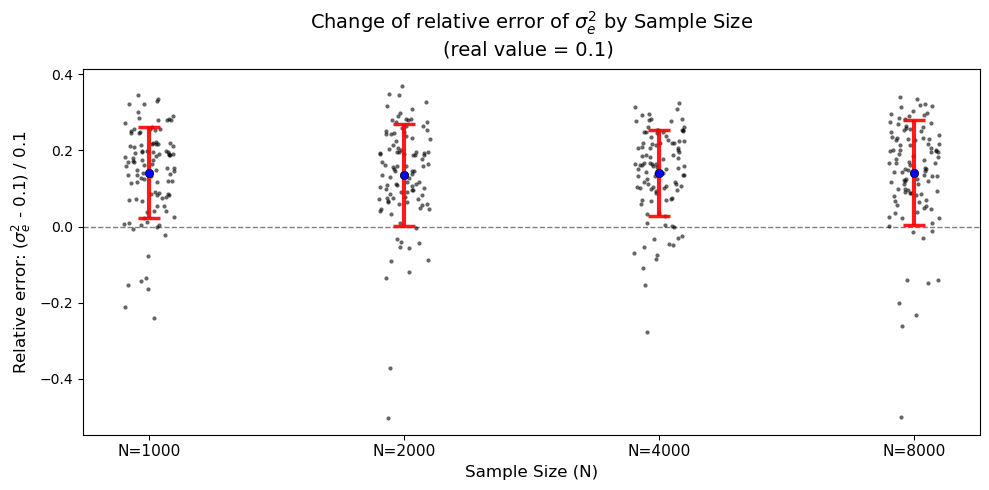

In [4]:
### experiment7: extension from experiment5 but LD pruning with r^2 > 0.5 and maf >0.05
## after pruning, the SNP number is 300(original 10k)
#### visualise cluster result
individual_sizes = [1000,2000,4000,8000]
result = read_MoM_results(individual_sizes,"../test_data/MoM_result_ContiguousSNP_after_pruning_05_SNP_304 _maf_005/",304)
df_pruning_05 = [result[n] for n in individual_sizes]

plot_relative_error_accross_sample_size(
    *df_pruning_05, 
    basic_individual=1000, col_num=0, real_value=0.9
)

plot_relative_error_accross_sample_size(
    *df_pruning_05, 
    basic_individual=1000, col_num=1, real_value=0.1
)

### Experiment

We investigate three factors that may affect gxg heritability ($h^2_{g \times g}$) estimation: linkage disequilibrium (LD), minor allele frequency (MAF), and number of SNPs. We categorize our test data into 12 groups using the following criteria:

**LD levels (3 bins):**
- High LD: SNPs pruned at $r^2 > 0.9$
- Medium LD: SNPs pruned at $r^2 > 0.5$
- Low LD: SNPs pruned at $r^2 > 0.2$

**MAF thresholds (2 bins):**
- All variants: no MAF filtering
- Common variants: MAF ≥ 0.05

**SNP count (2 bins):**
- Small dataset: ~500-600 SNPs
- Large dataset: ~1,200 SNPs

We examine how these factors influence estimation bias and standard error of $\hat h^2_{g \times g}$.

In [15]:
## highLD group

individual_sizes = [1000,2000,4000,8000]
result = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/",304)
df_pruning_05 = [result[n] for n in individual_sizes]

plot_relative_error_accross_sample_size(
    *df_pruning_05, 
    basic_individual=1000, col_num=0, real_value=0.9
)

plot_relative_error_accross_sample_size(
    *df_pruning_05, 
    basic_individual=1000, col_num=1, real_value=0.1
)

FileNotFoundError: [Errno 2] No such file or directory: '../test_data/All_simulation_result/1000m304.txt'